In [120]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [121]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [166]:
PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"
PATH_SAM="../Dati/12_APR/Run_chall_ChargeHistos_4_12_2024_10M.dat"
edge_N, bin_N = load_histo(PATH_SAM)

channel = 9

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

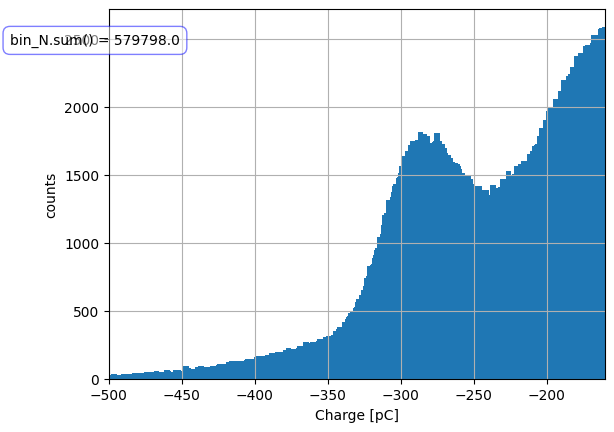

In [286]:
lim_list = [[-600, -165],  #ch0
            [-1, -1],      #ch1
            [-600, -175],  #ch2
            [-600, -145],  #ch3
            [-500, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-500, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [287]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [288]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [289]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

noise_params = noise_params[channel]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      6333     -inf      inf    92.31     True     None     None
e1_decay        -88.78     -inf      inf   0.5956     True     None     None
ratio            29.86     -inf      inf   0.8727    False e1_amplitude / s1_amplitude     None
s1_amplitude     212.1        0      inf    5.275     True     None     None
s1_center       -391.5     -inf      inf    1.296     True     None     None
s1_sigma         24.63        0      inf   0.9618     True     None     None


In [290]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "ratio * s1_amplitude")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 70348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["e1_amplitude"].set(min=0)
    params["e1_decay"].set(value=-61)

    params["s1_amplitude"].set(value= 1534, min = 0)
    params["s1_center"].set(value=-270)
    params["s1_sigma"].set( value= 60)

    params["ratio"].set( value=4.89)

if channel ==2:

    params["g1_amplitude"].set(value = 425000 , min=0)   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 5000, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].value = 54057.2496

    params["s1_amplitude"].set(min = 0)

if channel ==3:

    params["g1_amplitude"].set(value = 425000, min=0 )   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 675, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].set( min=0)
    params["e1_decay"].set(value=-93)
    
    params["s1_amplitude"].set(value=927, min = 0)

    params["ratio"].set(value=7.71)

if channel == 4:
    
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -290, min = -340 , max = -260)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 2)
   
if channel == 5:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -300, min = -330 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=50, max=1000)
    params["s2_center"].set(value = -180, min=-250,max=-150 )
    params["s2_sigma"].set(value = 9, min=0 )

    params["s1_amplitude"].set(value=1000)

if channel ==6:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -280, min = -320 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["s1_amplitude"].set(value=1000)

if channel ==7:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -340, min = -380 , max = -300)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

 
if channel == 8:
    params["g1_center"].set(value = -311)
    params["g1_sigma"].set(value = 14)
    params["e1_amplitude"].set(value = 6225)
    params["e1_decay"].set(value = -57)
    params["s1_amplitude"].set(value = 1380)
    params["s1_center"].set(value = -304)
    params["s1_sigma"].set(value = 14)
    params["s2_amplitude"].set(value = 885)
    params["s2_center"].set(value = -220)
    params["s2_sigma"].set(value = 11)


if channel == 9:
    params["g1_center"].value = -290
    params["g1_center"].min = -300
    params["g1_sigma"].value = 22
    params["g1_amplitude"].value = 60000

    params["e1_amplitude"].value = 12000
    params["e1_decay"].value = -60

    params["s2_center"].value = -250
    params["s2_center"].min = -340

    params["s2_amplitude"].value = 300
    params["s2_amplitude"].max = 930
    params["s2_amplitude"].min = 180
    params["s2_sigma"].value = 6
    params["s2_center"].value = -250


    params["s1_center"].value = -450 

    params["s1_amplitude"].value = 2000  
    params["s1_amplitude"].max = 10050    
  



if channel == 10:
    params["g1_center"].value = -400
    params["g1_center"].max = -380
    params["s2_amplitude"].max= 1000
    params["s2_center"].min = -350
    params["s2_center"].max = -150
         




    

    

params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  5.971e+04        0      inf     None    False ratio * s1_amplitude     None
e1_decay           -60     -inf      inf     None     True     None     None
g1_amplitude     6e+04        0      inf     None     True     None     None
g1_center         -290     -300      inf     None     True     None     None
g1_fwhm          51.81     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height         1088     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            22        0      inf     None     True     None     None
ratio            29.86     -inf      inf     None     True     None     None
s1_amplitude      2000        0 1.005e+04     None     True     None     None
s1_center         -450     -inf      inf     None     True     None     None
s1_sigma         24.63        0      inf     None     True     None     None
s2_amplitude   

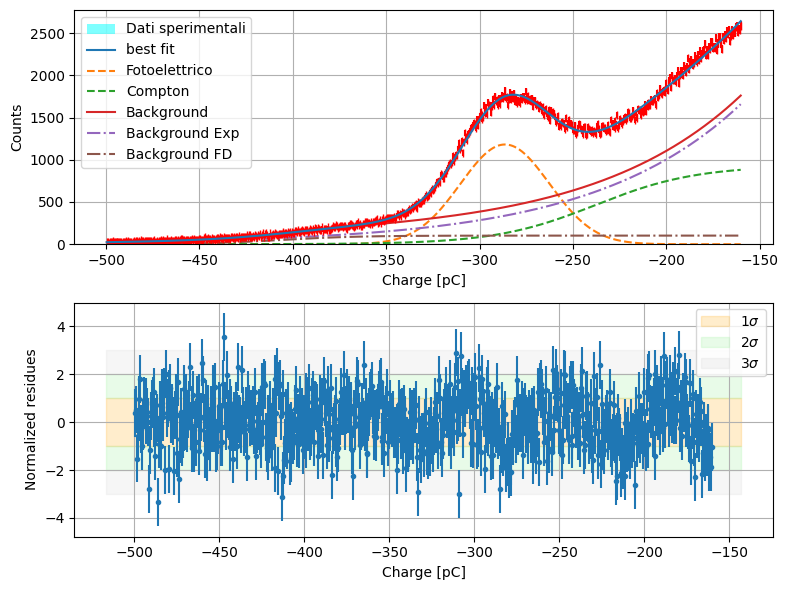

In [291]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [292]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1572
    # data points      = 654
    # variables        = 11
    chi-square         = 767.378811
    reduced chi-square = 1.19343517
    Akaike info crit   = 126.557083
    Bayesian info crit = 175.871264
    R-squared          = 0.99999820
[[Variables]]
    e1_amplitude:  12473.4876 +/- 2684.81530 (21.52%) == 'ratio * s1_amplitude'
    e1_decay:     -79.3271220 +/- 2.90424141 (3.66%) (init = -60)
    s1_amplitude:  102.030103 +/- 18.8507958 (18.48%) (init = 2000)
    s1_center:    -405.863079 +/- 5.32400006 (1.31%) (init = -450)
    s1_sigma:      20.6934827 +/- 2.67350547 (12.92%) (init = 24.62961)
    g1_amplitude:  70550.6858 +/- 5572.18636 (7.90%) (init = 60000)
    g1_center:    -286.358360 +/- 0.56142299 (0.20%) (init = -290)
    

## Sistematiche

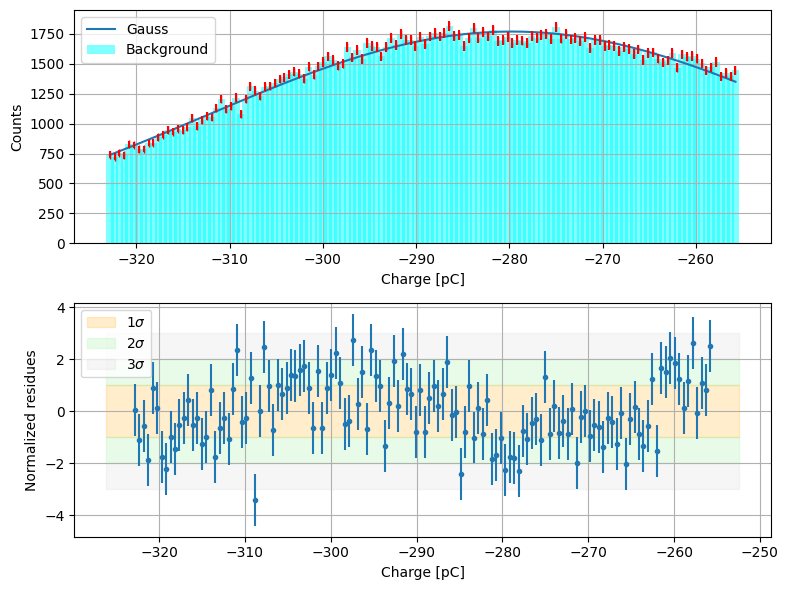

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 130
    # variables        = 3
    chi-square         = 207.889838
    reduced chi-square = 1.63692786
    Akaike info crit   = 67.0316024
    Bayesian info crit = 75.6342057
    R-squared          = 0.99998249
[[Variables]]
    g3_amplitude:  144576.587 +/- 1165.53243 (0.81%) (init = 85020)
    g3_center:    -279.737095 +/- 0.23817279 (0.09%) (init = -281.5104)
    g3_sigma:      32.5992745 +/- 0.31992789 (0.98%) (init = 26)
    g3_fwhm:       76.7654224 +/- 0.75337259 (0.98%) == '2.3548200*g3_sigma'
    g3_height:     1769.29450 +/- 6.97186732 (0.39%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9213
    C(g3_amplitude, g3_center) = +0.7285
    C(g3_center, g3_sigma)     = +0.6847


In [297]:
sist_lim_list = [[510, 605],  #ch0
                [-1, -1],  #ch1
                [460, 565],  #ch2
                [480, 595],  #ch3
                [350, 430],  #ch4
                [550, 630],  #ch5
                [550, 660],  #ch6
                [250, 350],  #ch7
                [500, 600],  #ch8
                [340, 470],  #ch9
                [380, 470],  #ch10
                [-600, -165],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [-600, -140],  #ch14
                [-600, -160]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())